# IMPORTS

In [29]:
#Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from itertools import product
from PIL import Image
from math import ceil

# Scikit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

# DATA PREP

### Load and Split

In [30]:
# Load the data
data_train = np.load('fashion_train.npy', mmap_mode = 'r')
data_test = np.load('fashion_test.npy', mmap_mode = 'r')

# Split and normalize the data
# We divide the X arrays by 255 to ensure they lay in the range [0, 1].
# We can do this scaling before splitting into training and validation in KFolds since
# it is by a constant already known value (255)
X_train = data_train[:, :-1] / 255
y_train = data_train[:, -1]
X_test = data_test[:, :-1] / 255
y_test = data_test[:, -1]

# CNN

In [41]:
# Create custom CNN model
class CNN(nn.Module):
    '''
    A custom Convolutional Neural Network model for image classification.

    Params:
        n_classes (int): Number of output classes.
        activation_fn (torch.nn.modules.activation): Activation function to use in the network layers.
        learning_rate (float): Learning rate for the optimizer.
        dropout_rate (float): Dropout rate for dropout layers.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (torch.nn.modules.loss): Loss function.
        tr_data (torch.utils.data.Dataset): Training dataset.
        val_data (torch.utils.data.Dataset): Validation dataset.
        batch_size (int): Batch size used for data loading.
        n_epochs (int, optional): Number of epochs for training. Defaults to 100.
        patience (int, optional): Number of epochs to wait for improvement before stopping. Defaults to 10.
        verbose (bool, optional): Flag to enable printing of training and validation statistics. Defaults to False.
    '''
    def __init__(self, n_classes, activation_fn, learning_rate, dropout_rate, optimizer, criterion, tr_data, val_data, batch_size, n_epochs = 100, patience = 10, verbose = False):
        
        super(CNN, self).__init__()

        # Define functions
        self.activation_fn = activation_fn
        self.criterion = criterion

        # Define variables
        self.n_epochs = n_epochs
        self.patience = patience
        self.verbose = verbose
        self.batch_size = batch_size

        # Keep statistics
        self.best_epoch = 0 # Use as key to find values in below dicts
        self.train_losses = {0: float('inf')}
        self.train_accuracies = {0: 0}
        self.val_losses = {0: float('inf')}
        self.val_accuracies = {0: 0}

        # Define data sets
        self.tr_loader = DataLoader(tr_data, batch_size = batch_size, shuffle = True)
        self.val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False)

        ### DEFINE ARCHITECTURE

        # First convolutional block
        self.conv1_block = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size = 5, stride = 1, padding = 2),
            nn.BatchNorm2d(6),
            self.activation_fn(),
            nn.AvgPool2d(kernel_size = 2, stride = 2)
        )

        # Second convolutional block
        self.conv2_block = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.BatchNorm2d(16),
            self.activation_fn(),
            nn.AvgPool2d(kernel_size = 2, stride = 2)
        )

        # Fully connected layers
        self.fc_block = nn.Sequential(

            # First fully connected layer
            nn.Dropout(dropout_rate),
            nn.Linear(16 * 5 * 5, 120),
            nn.BatchNorm1d(120),
            self.activation_fn(),

            # Second fully connected layer
            nn.Dropout(dropout_rate),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            self.activation_fn(),

            # Output layer
            nn.Dropout(dropout_rate),
            nn.Linear(84, n_classes)
        )

        # Define optimizer
        self.optimizer = optimizer(self.parameters(), lr = learning_rate)

        # Define schedular for reducing learning rates
        self.schedular = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer = self.optimizer,
            patience = ceil(self.patience / 2), # Reduces learning rate once half of patience has passed
            verbose = self.verbose
        )
    
    def forward(self, x):
        '''
        Forward pass of the model.

        Params:
            x (torch.Tensor): Input data.

        Returns:
            output (torch.Tensor): Output of the model.
        '''
        output = self.conv1_block(x) # First convolutional block
        output = self.conv2_block(output) # Second convolutional block
        output = output.reshape(output.size(0), -1) # Flatten before passing to fully connected layers
        output = self.fc_block(output) # Apply the fully connected layers
        return output

    def train_loop(self):
        '''
        Training loop for a single epoch. Processes the training data in batches,
        performs forward and backward passes, and updates model parameters.
        '''
        # Enable batch normalization and dropout
        self.train()

        # Initiate training statistics
        train_loss = .0
        train_correct = 0

        # Iterate over each batch in training loader
        for imgs, labels in self.tr_loader:

            # Forward step
            outputs = self.forward(imgs)
            loss = self.criterion(outputs, labels)

            # Backwards step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update loss and correct
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        # Compute average training loss and training accuracy
        avg_train_loss = train_loss / len(self.tr_loader) # Divide by number of batches
        train_accuracy = train_correct / len(self.tr_loader.dataset) * 100 # Divide by number of observations

        # Add average training loss and accuracy for the epoch to model statistics
        self.train_losses[self.epoch] = avg_train_loss
        self.train_accuracies[self.epoch] = train_accuracy

    def val_loop(self):
        '''
        Validation loop for a single epoch. Processes the validation data in batches
        and evaluates the model's performance.
        '''
        # Disable batch batch normalization and dropout
        self.eval()

        # Initiate validation statistics
        val_loss = .0
        val_correct = 0

        with torch.no_grad():  # Do not use gradient for validation
            for imgs, labels in self.val_loader:

                outputs = self.forward(imgs)
                loss = self.criterion(outputs, labels)

                # Update loss and correct
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        # Compute average validation loss and validation accuracy
        avg_val_loss = val_loss / len(self.val_loader) # Divide by number of batches
        val_accuracy = val_correct / len(self.val_loader.dataset) * 100 # Divide by number of observations

        # Add average validation loss and accuracy for the epoch to model statistics
        self.val_losses[self.epoch] = avg_val_loss
        self.val_accuracies[self.epoch] = val_accuracy

        # Step the schedular based on the validation loss
        self.schedular.step(val_loss)

    def fit(self):
        '''
        Run the fitting process for the model. Iteratively calls the training and validation
        loops for the specified number of epochs, with early stopping based on validation loss.
        '''
        # Run training and validation loop once for every epoch
        for epoch in range(self.n_epochs):

            # Keep track of current epoch
            self.epoch = epoch + 1 # Start from 1

            # Run training loop
            self.train_loop()

            # Run validation loop
            self.val_loop()

            # Print training and validation statistics
            if self.verbose: # and (epoch + 1) % 5 == 0:
                print(f'Epoch {self.epoch}/{self.n_epochs}, ',
                    f'Train Loss: {self.train_losses[self.epoch]:.4f}, ',
                    f'Train Accuracy: {self.train_accuracies[self.epoch]:.2f}%, ',
                    f'Val Loss: {self.val_losses[self.epoch]:.4f}, ',
                    f'Val Accuracy: {self.val_accuracies[self.epoch]:.2f}%')

            # Run evaluation and break if patience have been met
            if self.evaluate_epoch():
                break

    def evaluate_epoch(self):
        '''
        Evaluate the model at the end of an epoch. Checks if the validation loss has improved
        and updates the best model if necessary.

        Returns:
            bool: True if early stopping condition is met, False otherwise.
        '''
        # Check if validation loss for current epoch is improvement
        if self.val_losses[self.epoch] < self.val_losses[self.best_epoch]:
            self.best_epoch = self.epoch # Update best epoch
            self.epochs_without_improvement = 0 # Create/reset early stopping counter variable
            self.save_model() # Safe this as new best model
        else:
            self.epochs_without_improvement += 1

        # Check if paitence for epochs without improvement have been reached
        if self.epochs_without_improvement >= self.patience:
            if self.verbose:
                print(f'Stopping at epoch {self.epoch} due to no improvement in validation loss over {self.patience} epochs.') 
            return True # Will break fit loop

    def predict(self, pred_data, batch_size = None):
        '''
        Make predictions with the trained model.

        Params:
            pred_data (torch.utils.data.Dataset): The test data for making predictions.

        Returns:
            numpy.ndarray: Predicted labels for the test data.
        '''
        # Disable batch batch normalization and dropout
        self.eval()

        # Use initialized batch size if nothing else specified
        if batch_size == None:
            batch_size = self.batch_size

        # Create data loader for prediction data
        pred_loader = DataLoader(pred_data, batch_size = batch_size, shuffle = False)

        # Keep predictions in list
        y_pred = []

        with torch.no_grad(): # Do not use gradient for prediction
            for X, _ in pred_loader:
                logits = self.forward(X)
                y_pred.append(logits.argmax(dim = 1))

        # Concatenate y_pred
        y_pred = torch.cat(y_pred, dim = 0)

        return y_pred.numpy() # Return as numpy array
    
    def test(self, test_data, batch_size = None):
        '''
        Test loop for evaluating the model on test data. Computes the loss and accuracy.

        Params:
            test_data (torch.utils.data.Dataset): The test dataset for evaluation.

        Returns:
            dict: Dictionary containing 'Test Loss' and 'Test Accuracy'.
        '''
        # Disable batch batch normalization and dropout
        self.eval()

        # Use initialized batch size if nothing else specified
        if batch_size == None:
            batch_size = self.batch_size

        # Create data loader for test data
        test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

        # Initiate test statistics
        test_loss = .0
        test_correct = 0

        with torch.no_grad(): # Do not use gradient for testing
            for imgs, labels in test_loader:

                outputs = self.forward(imgs)
                loss = self.criterion(outputs, labels)

                # Update loss and correct
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_correct += (predicted == labels).sum().item()

        # Compute average testing loss and accuracy
        avg_test_loss = test_loss / len(test_loader) # Divide by number of batches
        test_accuracy = test_correct / len(test_loader.dataset) * 100 # Divide by number of observations

        # Return dict of statistics
        return {'Test Loss': avg_test_loss, 'Test Accuracy': test_accuracy}

    def save_model(self, file_path = 'best_model.pth'):
        '''
        Save the current state of the model to a file.

        Params:
            file_path (str, optional): The file path to save the model. Defaults to 'best_model.pth'.
        '''
        torch.save(self.state_dict(), file_path)

    def load_model(self, file_path = 'best_model.pth'):
        '''
        Load a model's state from a file.

        Params:
            file_path (str, optional): The file path to load the model from. Defaults to 'best_model.pth'.
        '''
        self.load_state_dict(torch.load(file_path))
        self.eval() # Set the model to evaluation mode


# CROSS VALIDATION

In [32]:
# Define ranges of learning and dropout rates
learning_rates = [.0001, .001, .0025, .01, .025, .1, .25]
dropout_rates = [.0001, .001, .0025, .01, .1, .2, .3] # [.0001, .001, .0025, .01, .1, .2, .3, .4, .5] 

# Define batch size
batch_size = 64

# Define number of folds for cross-validation
n_folds = 5
kf = KFold(n_splits = n_folds, shuffle = True, random_state = 17)

# Initialiaze empty data frame to store results
results_columns = ['LR', 'DPR', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy']
results = pd.DataFrame(columns = results_columns)

# Print startup message
print('-'*60)
print('Running Cross Validation...')
print('-'*60)
print(f'Testing {len(learning_rates)} learning rates and {len(dropout_rates)} dropout rates for a total')
print(f'of {len(learning_rates) * len(dropout_rates)} combinations, each split into {n_folds} folds.')
print('-'*60)
hours, mins = divmod(1.9 * len(learning_rates) * len(dropout_rates) * n_folds, 60) # 1.9 multiplier is rough guess based on previous performance
print(f'Expected time: {int(hours)} hours, {mins} minutes.')
print('-'*60)

# Take cartesian product to iterate over each combination of learning rate and dropout rate
for learning_rate, dropout_rate in product(learning_rates, dropout_rates):
    
    print('\n')
    print('-'*51)
    print(f'--- Learning Rate: {learning_rate:.4f}, Dropout Rate: {dropout_rate:.4f} ---')
    print('-'*51)

    # Lists to store statistics accuracies for each fold
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Iterate over cross-validation folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):

        # Split data into training and validation sets for this fold
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        # Convert to tensors
        X_train_fold_tensor = torch.tensor(X_train_fold, dtype = torch.float32).view(-1, 1, 28, 28) # Convert to convolutional input
        y_train_fold_tensor = torch.tensor(y_train_fold, dtype = torch.long)
        X_val_fold_tensor = torch.tensor(X_val_fold, dtype = torch.float32).view(-1, 1, 28, 28) # Convert to convolutional input
        y_val_fold_tensor = torch.tensor(y_val_fold, dtype = torch.long)

        # Create tensor datasets
        train_fold_dataset = TensorDataset(X_train_fold_tensor, y_train_fold_tensor)
        val_fold_dataset = TensorDataset(X_val_fold_tensor, y_val_fold_tensor)

        # Instantiate model
        model = CNN(
            n_classes = len(np.unique(y_train)),
            activation_fn = nn.Sigmoid,
            learning_rate = learning_rate,
            dropout_rate = dropout_rate,
            optimizer = torch.optim.Adam,
            criterion = nn.CrossEntropyLoss(reduction = 'mean'),
            tr_data = train_fold_dataset,
            val_data = val_fold_dataset,
            n_epochs = 100,
            batch_size = batch_size,
            verbose = True
        )

        print(f'\nRunning Fold {fold + 1}/{n_folds}..')

        # Fit model
        model.fit()

        # Get model statistics for this fold
        fold_best_epoch = model.best_epoch
        fold_best_epoch_tr_loss = model.train_losses[fold_best_epoch]
        fold_best_epoch_tr_acc = model.train_accuracies[fold_best_epoch]
        fold_best_epoch_val_loss = model.val_losses[fold_best_epoch]
        fold_best_epoch_val_acc = model.val_accuracies[fold_best_epoch]

        # Append fold statistic to lr/dpr combination statistics
        train_losses.append(fold_best_epoch_tr_loss)
        train_accuracies.append(fold_best_epoch_tr_acc)
        val_losses.append(fold_best_epoch_val_loss)
        val_accuracies.append(fold_best_epoch_val_acc)

        print(
            f'Results for Fold {fold + 1}/{n_folds}:\n',
            f'Best Epoch: {fold_best_epoch}, ',
            f'Train Loss: {fold_best_epoch_tr_loss:.4f}, ',
            f'Train Accuracy: {fold_best_epoch_tr_acc:.2f}%, '
            f'Val Loss: {fold_best_epoch_val_loss:.4f}, ', 
            f'Val Accuracy: {fold_best_epoch_val_acc:.2f}%'
        )

    # Update results data frame with data from combination of learning rate and dropout rate
    results = results.append({
        'LR': learning_rate,
        'DPR': dropout_rate,
        'Train Loss': sum(train_losses) / len(train_losses),
        'Train Accuracy': sum(train_accuracies) / len(train_accuracies),
        'Val Loss': sum(val_losses) / len(val_losses),
        'Val Accuracy': sum(val_accuracies) /len(val_accuracies)
    }, ignore_index = True)

    print(f'\nFinal Results for Learning Rate {learning_rate} and Dropout Rate {dropout_rate}:\n',
          f'Avg Train Loss: {sum(train_losses) / len(train_losses):.4f}, ',
          f'Avg Train Accuracy: {sum(train_accuracies) / len(train_accuracies):.2f}%, ',
          f'Avg Val Loss: {sum(val_losses) / len(val_losses):.4f}, ', 
          f'Avg Val Accuracy: {sum(val_accuracies) /len(val_accuracies):.2f}%')

# Save results to csv
results.to_csv('cross_validation2.csv')
print('\n', results)

# Extract best combination of learning rate and dropout rate from results data frame
# based on lowest validation loss
lowest_val_loss_idx = results.loc[results['Val Loss'].idxmin()]
best_combination = lowest_val_loss_idx['LR'], lowest_val_loss_idx['DPR'] # Save to tuple

------------------------------------------------------------
Running Cross Validation...
------------------------------------------------------------
Testing 7 learning rates and 7 dropout rates for a total
of 49 combinations, each split into 5 folds.
------------------------------------------------------------
Expected time: 7 hours, 45.5 minutes.
------------------------------------------------------------


---------------------------------------------------
--- Learning Rate: 0.0001, Dropout Rate: 0.0001 ---
---------------------------------------------------

Running Fold 1/5..
Epoch 1/100,  Train Loss: 1.2292,  Train Accuracy: 57.71%,  Val Loss: 1.0554,  Val Accuracy: 76.30%
Epoch 2/100,  Train Loss: 1.0062,  Train Accuracy: 77.11%,  Val Loss: 0.9477,  Val Accuracy: 79.15%
Epoch 3/100,  Train Loss: 0.9157,  Train Accuracy: 79.33%,  Val Loss: 0.8660,  Val Accuracy: 80.80%
Epoch 4/100,  Train Loss: 0.8471,  Train Accuracy: 80.80%,  Val Loss: 0.8066,  Val Accuracy: 81.65%
Epoch 5/10

# MODEL ANALYSIS AND TESTING

### Train new model on best combination of learning and dropout rate.

In [42]:
# Split training data into training and validation sets
X_train_new, X_val = X_train[:8000, :], X_train[2000:, :]
y_train_new, y_val = y_train[:8000], y_train[2000:]

# Convert to tensors
X_train_tensor = torch.tensor(X_train_new, dtype = torch.float32).view(-1, 1, 28, 28) # Convert to convolutional input
y_train_tensor = torch.tensor(y_train_new, dtype = torch.long)
X_val_tensor = torch.tensor(X_val, dtype = torch.float32).view(-1, 1, 28, 28) # Convert to convolutional input
y_val_tensor = torch.tensor(y_val, dtype = torch.long)
X_test_tensor = torch.tensor(X_test, dtype = torch.float32).view(-1, 1, 28, 28) # Convert to convolutional input
y_test_tensor = torch.tensor(y_test, dtype = torch.long)

# Create tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define batch size
batch_size = 64

# Create new model on training data based on best combination of learning and dropout rates
best_lr, best_dpr = best_combination
model = CNN(
            n_classes = len(np.unique(y_train)),
            activation_fn = nn.Sigmoid,
            learning_rate = best_lr,
            dropout_rate = best_dpr,
            optimizer = torch.optim.Adam,
            criterion = nn.CrossEntropyLoss(reduction = 'mean'),
            tr_data = train_dataset,
            val_data = val_dataset,
            n_epochs = 100,
            batch_size = batch_size,
            verbose = False
        )

# Fit model
model.fit()

### Plot Loss and Accuracy Statistics.

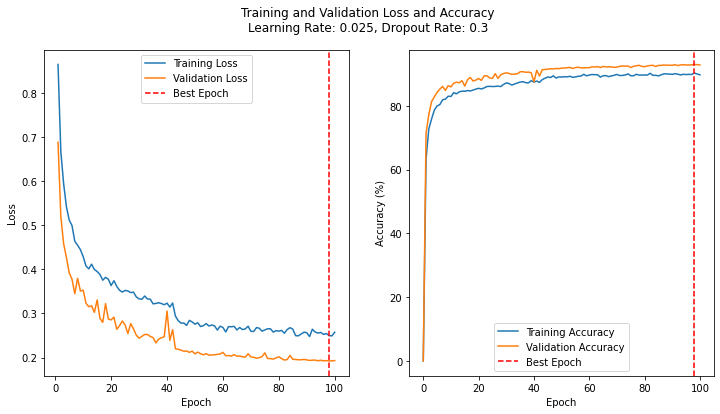

In [53]:
# Get loss and accuracy statistics
train_losses = model.train_losses
train_accuracies = model.train_accuracies
val_losses = model.val_losses
val_accuracies = model.val_accuracies

# Get best epoch statistic
best_epoch = model.best_epoch

# Plot curves
plt.figure(figsize = (12, 6))
plt.suptitle(f'Training and Validation Loss and Accuracy\nLearning Rate: {best_lr}, Dropout Rate: {best_dpr}')

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(list(train_losses.keys()), list(train_losses.values()), label = 'Training Loss')
plt.plot(list(val_losses.keys()), list(val_losses.values()), label = 'Validation Loss')
plt.axvline(best_epoch, color = 'red', linestyle = '--', label = 'Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(list(train_accuracies.keys()), list(train_accuracies.values()), label = 'Training Accuracy')
plt.plot(list(val_accuracies.keys()), list(val_accuracies.values()), label = 'Validation Accuracy')
plt.axvline(best_epoch, color = 'red', linestyle = '--', label = 'Best Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show plot
plt.show()

In [54]:
# Load best version of the model
model.load_model()

# Test model
test_statistics = model.test(test_data = test_dataset)
test_loss, test_accuracy = test_statistics['Test Loss'], test_statistics['Test Accuracy']
print(f'Test Results:\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Results:
Test Loss: 0.3129, Test Accuracy: 88.84%
